In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
# read in data
f = open('eng.txt')
eng_text = f.read()
f.close()

f = open('frn.txt')
frn_text = f.read()
f.close()

In [3]:
# clean strings
eng_text = eng_text.replace('\n',' ')
eng_text = eng_text.lower()

frn_text = frn_text.replace('\n', ' ')
frn_text = frn_text.lower()

In [4]:
# split strings into gram_size length sub-strings, skipping by step_size chars each slice
gram_size = 5
step_size = 1

# english
eng_sub_strs = []
eng_next_chars = []
for i in range(0,len(eng_text)-gram_size,step_size):
    sub_str = eng_text[i:i+gram_size]
    eng_sub_strs.append(sub_str)
    eng_next_chars.append(eng_text[i+gram_size])
    
# french
frn_sub_strs = []
frn_next_chars = []
for i in range(0,len(frn_text)-gram_size,step_size):
    sub_str = frn_text[i:i+gram_size]
    frn_sub_strs.append(sub_str)
    frn_next_chars.append(frn_text[i+gram_size])

In [5]:
# create dictionaries mapping characters to their feature (column) index
unique_chars = sorted(list(set(eng_text+frn_text)))
char2idx = {}
idx2char = {}
for i,c in enumerate(unique_chars):
    char2idx[c] = i
    idx2char[i] = c

In [6]:
# vectorize substrings

# english
X_eng = np.zeros((len(eng_sub_strs), gram_size, len(unique_chars)))
y_eng = np.zeros((len(eng_sub_strs), len(unique_chars)))

for i in range(len(eng_sub_strs)):
    sub_str = eng_sub_strs[i]
    vec = np.zeros((gram_size, len(unique_chars)))
    for j in range(len(sub_str)):
        char = sub_str[j]
        idx = char2idx[char]
        vec[j,idx] = 1
        
    X_eng[i,:,:] = vec
    
    next_char = eng_next_chars[i]
    idx = char2idx[next_char]
    y_eng[i, idx] = 1

# french
X_frn = np.zeros((len(frn_sub_strs), gram_size, len(unique_chars)))
y_frn = np.zeros((len(frn_sub_strs), len(unique_chars)))

for i in range(len(frn_sub_strs)):
    sub_str = frn_sub_strs[i]
    vec = np.zeros((gram_size, len(unique_chars)))
    for j in range(len(sub_str)):
        char = sub_str[j]
        idx = char2idx[char]
        vec[j,idx] = 1

    X_frn[i,:,:] = vec
    
    next_char = frn_next_chars[i]
    idx = char2idx[next_char]
    y_frn[i, idx] = 1


In [7]:
# split into train and test sets

X_eng_train, X_eng_test, y_eng_train, y_eng_test = train_test_split(
    X_eng, y_eng, test_size=0.2, random_state=1993)

X_frn_train, X_frn_test, y_frn_train, y_frn_test = train_test_split(
    X_frn, y_frn, test_size=0.2, random_state=1993)

In [8]:
print(X_eng_train.shape, X_eng_test.shape)
print(y_eng_train.shape, y_eng_test.shape)
print()
print(X_frn_train.shape, X_frn_test.shape)
print(y_frn_train.shape, y_frn_test.shape)

(8592, 5, 43) (2149, 5, 43)
(8592, 43) (2149, 43)

(9603, 5, 43) (2401, 5, 43)
(9603, 43) (2401, 43)


In [9]:
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input
from keras.layers import LSTM
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [10]:
eng_model = Sequential()

lstm_layer = LSTM(128, input_shape=(gram_size,len(unique_chars)))
eng_model.add(lstm_layer)

pred_layer = Dense(len(unique_chars))
eng_model.add(pred_layer)

pred_layer = Activation('softmax')
eng_model.add(pred_layer)

optimizer = RMSprop(lr=0.01)
eng_model.compile(loss='categorical_crossentropy', optimizer=optimizer)

eng_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               88064     
_________________________________________________________________
dense_1 (Dense)              (None, 43)                5547      
_________________________________________________________________
activation_1 (Activation)    (None, 43)                0         
Total params: 93,611.0
Trainable params: 93,611.0
Non-trainable params: 0.0
_________________________________________________________________


In [11]:
frn_model = Sequential()

lstm_layer = LSTM(128, input_shape=(gram_size,len(unique_chars)))
frn_model.add(lstm_layer)

pred_layer = Dense(len(unique_chars))
frn_model.add(pred_layer)

pred_layer = Activation('softmax')
frn_model.add(pred_layer)

optimizer = RMSprop(lr=0.01)
frn_model.compile(loss='categorical_crossentropy', optimizer=optimizer)

frn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               88064     
_________________________________________________________________
dense_2 (Dense)              (None, 43)                5547      
_________________________________________________________________
activation_2 (Activation)    (None, 43)                0         
Total params: 93,611.0
Trainable params: 93,611.0
Non-trainable params: 0.0
_________________________________________________________________


In [12]:
# train english model
eng_model.fit(X_eng_train, y_eng_train,
         epochs=5,
         batch_size=128,
         shuffle=True,
         verbose=2)

Epoch 1/5
1s - loss: 2.6469
Epoch 2/5
0s - loss: 2.0193
Epoch 3/5
0s - loss: 1.7432
Epoch 4/5
0s - loss: 1.5398
Epoch 5/5
0s - loss: 1.3658


In [13]:
# train french model
frn_model.fit(X_frn_train, y_frn_train,
             epochs=5,
             batch_size=128,
             shuffle=True,
             verbose=2)

Epoch 1/5
1s - loss: 2.5411
Epoch 2/5
0s - loss: 1.9819
Epoch 3/5
0s - loss: 1.7464
Epoch 4/5
0s - loss: 1.5730
Epoch 5/5
0s - loss: 1.4171


In [14]:
# build language prediction model on top of english and french LSTMs

def model_predict(test_gram):
    
    # insert zero vector at 0th position to indicate START
    start = np.zeros((1,len(unique_chars)))
    test_gram = np.insert(test_gram, 0, start, axis=0)
    
    # initialize log probability metrics
    gram_log_prob_eng = 0.
    gram_log_prob_frn = 0.
    
    # calculate the probability the next character will be the true character,
    # given the previous characters, for all characters in test_gram
    # essentially the predicted values correspond to 
    # P('t'|START), P('r'|START,'t'), P('u'|START,'t','r'), etc.
    for i in range(1,test_gram.shape[0]):
        
        # pad gram with 0 vectors to indicate START
        # an analogous example: 
        # the string 'trump' is split as: '00000' -> 't', '0000t' -> 'r', '000tr' -> 'u', etc.
        pad = np.repeat(start, gram_size-i, axis=0)
        
        # reformat test_gram for prediction
        temp_gram = test_gram[:i,:]
        temp_gram = np.append(pad, temp_gram, axis=0)
        temp_gram = temp_gram.reshape((1, gram_size, len(unique_chars)))
        
        # predict probability the next char will be the true char for english and french
        y_hat_eng = eng_model.predict(temp_gram)[0]
        y_hat_frn = frn_model.predict(temp_gram)[0]
        
        next_char = test_gram[i,:]
        idx = list(next_char).index(1)
        
        log_prob_eng = np.log(y_hat_eng[idx])
        log_prob_frn = np.log(y_hat_frn[idx])
        
        # add log(P(temp_gram|chars before)) to total log prob
        gram_log_prob_eng += log_prob_eng
        gram_log_prob_frn += log_prob_frn
        
        #next_char = idx2char[idx] 
        #print(i,next_char,log_prob_eng, gram_log_prob_eng, log_prob_frn, gram_log_prob_frn)
    
    y_hat = gram_log_prob_eng/gram_log_prob_frn
    
    return gram_log_prob_eng,gram_log_prob_frn,y_hat
    

In [15]:
eng_log_probs = []
frn_log_probs = []

eng_scores = []
for i in range(X_eng_test.shape[0]):
    eng_log_prob, frn_log_prob, score = model_predict(X_eng_test[i,:,:])
    
    eng_log_probs.append(eng_log_prob)
    frn_log_probs.append(frn_log_prob)
    eng_scores.append(score)

frn_scores = []
for i in range(X_frn_test.shape[0]):
    eng_log_prob, frn_log_prob, score = model_predict(X_frn_test[i,:,:])
    
    eng_log_probs.append(eng_log_prob)
    frn_log_probs.append(frn_log_prob)
    frn_scores.append(score)

In [16]:
y_true = [1 for i in range(len(eng_scores))]+[0 for i in range(len(frn_scores))]

In [17]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

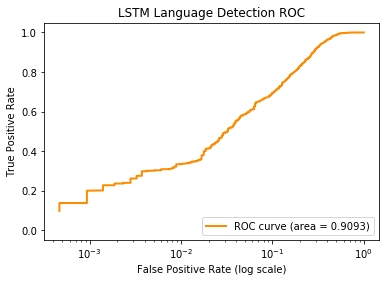

In [18]:
tpr, fpr, _ = roc_curve(y_true, eng_scores+frn_scores)
roc_auc = auc(fpr, tpr)

#plot the ROC-AUC curve
plt.figure()
plt.semilogx(fpr, tpr, color='darkorange', lw=2,
         label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (log scale)')
plt.ylabel('True Positive Rate')
plt.title('LSTM Language Detection ROC')
plt.legend(loc="lower right")
plt.show()